In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import time
import ot.plot
import torch
from IPython import display
import pandas as pd

In [2]:
import sys
import os
from ICP import procruste,ICP,get_SWGG_smooth,SWGG_smooth,SWGG_parallel
from utils import load_image,draw_samples,rotation_matrix,Y_to_X,sinkhorn,plot_cloud

In [3]:
"""if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)"""

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

In [34]:
#Loading Data

#From .png
xt=10*draw_samples("data/density_b.png", n=200).numpy()

#From .pts
xt=np.loadtxt('data/mumble_sitting_3000.pts', comments=("version:", "n_points:", "{", "}"))
#xt=np.loadtxt('data/WitchCastle_150000.pts', comments=("version:", "n_points:", "{", "}"))

n,dim=xt.shape
print(xt.shape)

(3000, 3)


'\n### Artificial Resolution ###\nR,t=procruste(X, Y)\nXtemp=X+t\nXtemp=Xtemp@(R.T)\nplot_cloud(Xtemp,Y,s=1)'

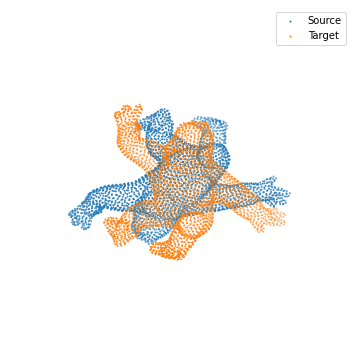

In [41]:
Y = torch.from_numpy(xt).to(device)
Y-=torch.mean(Y,axis=0)
X=Y_to_X(Y,trans=5,eps=.1)

plot_cloud(X,Y,s=1)

"""
### Artificial Resolution ###
R,t=procruste(X, Y)
Xtemp=X+t
Xtemp=Xtemp@(R.T)
plot_cloud(Xtemp,Y,s=1)"""

# ICP

In [42]:
method=['swgg','nearest','ot']
s=len(method)

max_iter=50

_,_,X_l1,loss_l1,time1,n1=ICP(X,Y,pairs='swgg', max_iter=max_iter, tol=1e-3,n_proj=5)
_,_,X_l2,loss_l2,time2,n2=ICP(X,Y,pairs='nearest', max_iter=max_iter, tol=1e-3)
_,_,X_l3,loss_l3,time3,n3=ICP(X,Y,pairs='ot', max_iter=max_iter, tol=1e-4)


X_l=[X_l1,X_l2,X_l3]
loss_l=torch.concat((loss_l1[:,None],loss_l2[:,None],loss_l3[:,None]),dim=1)
timming=torch.tensor([time1,time2,time3])
nb_ite=torch.tensor([n1,n2,n3])

## Plot the result

In [43]:
label=['Final Loss', 'Timming','Nb of iterations']
res=torch.zeros((3,3))
res[:,0]=loss_l[-1,:]
res[:,1]=timming
res[:,2]=nb_ite
table=pd.DataFrame(res, columns=label,index=method)
table = table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
table

,Final Loss,Timming,Nb of iterations
swgg,1.153230,9.346028,49.000000
nearest,18.327937,9.487016,49.000000
ot,65.979452,28.327590,19.000000


# Plot the Iterations

In [39]:
foldername = './Gif_ICP'
if not os.path.isdir(foldername):
    os.mkdir(foldername)

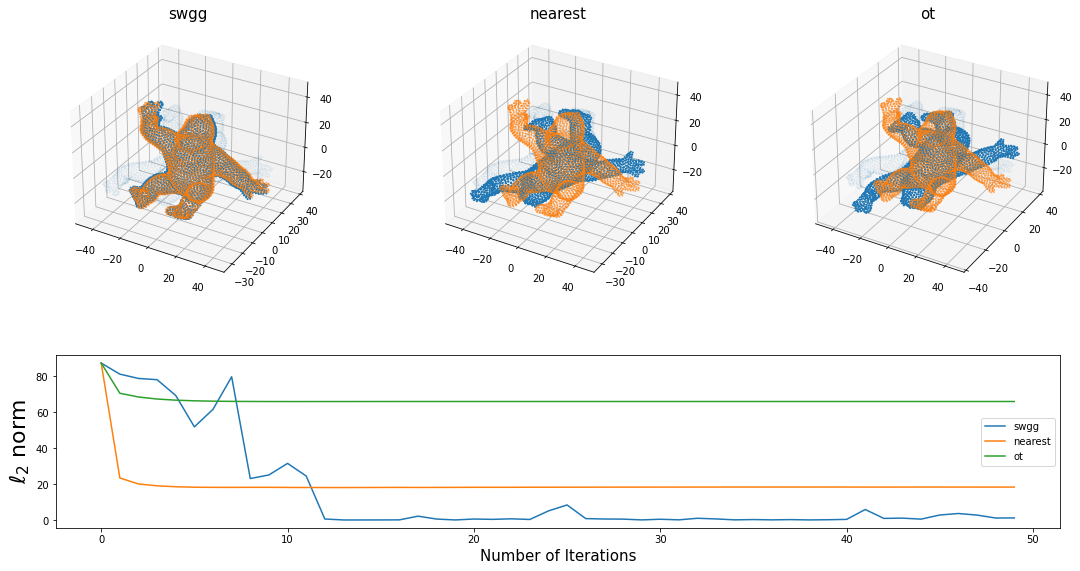

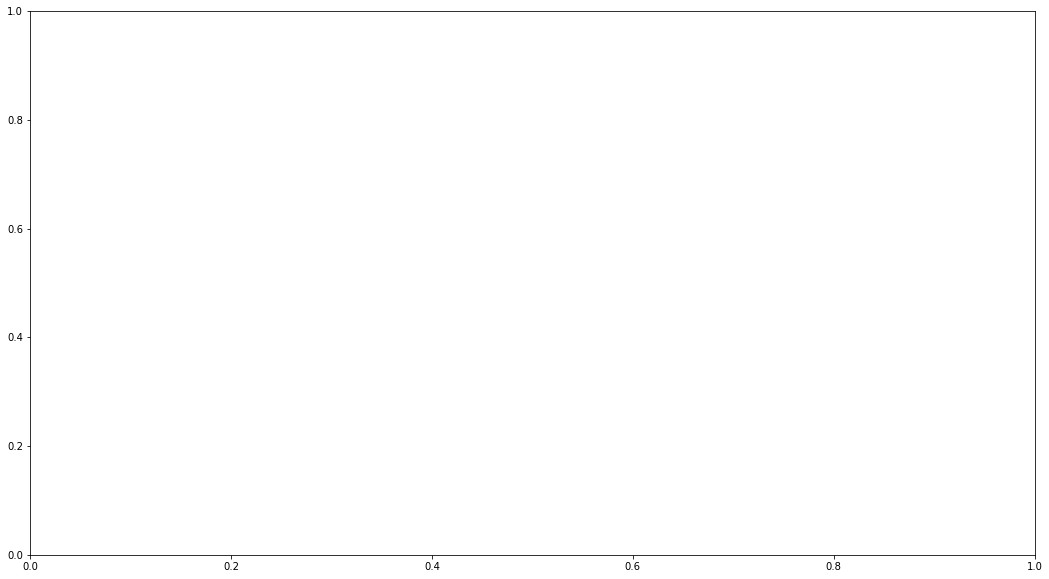

In [44]:
size=1
fig = pl.figure(figsize=(s*6, 10))
grid = pl.GridSpec(2, s, wspace=.4, hspace=0.1,height_ratios=[2, 1])

for j in range(max_iter):
    for i in range(s):
        X_temp=X_l[i]
        dim=X_temp.shape[1]
        
        if dim==2:
            pl.subplot(grid[0,i])
            #ot.plot.plot2D_samples_mat(X_temp, xt, P_l[i][j], c=[0,0,0],alpha=0.2)
            pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.05,s=size)
            pl.scatter(X_temp[:, 0,j], X_temp[:, 1,j], c='C0', label='Source',alpha=1,s=size)
            pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.5,s=size)
            pl.title(method[i], fontsize=15)
            #pl.legend()
        if dim==3:
            pl.subplot(grid[0,i],projection='3d')
            pl.scatter(X[:,0],X[:,1],zs=X[:,2],c='C0',s=size,label='Source',alpha=0.05)
            pl.scatter(X_temp[:, 0,j], X_temp[:, 1,j],zs=X_temp[:,2,j], c='C0', label='Source',alpha=1,s=size)
            pl.scatter(Y[:,0],Y[:,1],zs=Y[:,2],c='C1',s=size,label='Target',alpha=0.5)
            pl.title(method[i], fontsize=15)
            #pl.legend()
         
    pl.subplot(grid[1,:])
    for i in range(s):
        pl.plot(loss_l[:j+1,i],color='C%i'%i,label=method[i])
        pl.xlabel('Number of Iterations', fontsize=15)
        pl.ylabel(r'$\ell_2$ norm', fontsize=22)
        pl.legend()
        
    fig.savefig(foldername + '/img%03d.png'%(j))
    
    display.clear_output(wait=True)
    display.display(pl.gcf()) 
    time.sleep(1e-5)
    pl.subplot(grid[:, :])
    pl.cla()
            